## Import data

In [1]:
import os
import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def read_feature(folder, num):
    filename = glob.glob(os.path.join(folder, '*'))
    img_arr = np.zeros([len(filename), 100, 100, 3])
    label = num * np.ones(len(filename), dtype="float32")
    for i, name in enumerate(filename):
        img = Image.open(name)
        img_arr[i, :, :, :] = np.asarray(img, dtype="uint8")
    return img_arr, label

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(8076, 100, 100, 3)
(8076,)
Training data shape (7268, 100, 100, 3)


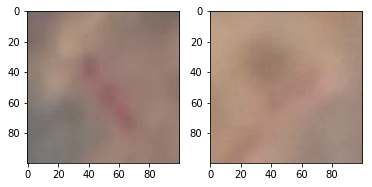

In [2]:
tb_img_arr, tb_label = read_feature('./TB_Image', 1)
non_tb_img_arr, non_tb_label = read_feature('./Non-TB_Image', 0)
images = np.concatenate((tb_img_arr, non_tb_img_arr))
labels = np.concatenate((tb_label, non_tb_label))

print(np.shape(images))
print(np.shape(labels))
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1)

X_train = X_train.astype(np.uint8)
X_val = X_val.astype(np.uint8)
y_train = y_train.astype(np.uint8)
y_val = y_val.astype(np.uint8)

# change into one-hot vector
#y_train = tf.keras.utils.to_categorical(y_train, 2) 
#y_val = tf.keras.utils.to_categorical(y_val, 2)

# reshape dataset
X_train = X_train.reshape(X_train.shape[0], 100, 100, 3)
X_val = X_val.reshape(X_val.shape[0], 100, 100, 3)

from matplotlib import pyplot as plt
%matplotlib inline

print('Training data shape', X_train.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(100, 100, 3), cmap=plt.cm.Greys);
ax2.imshow(X_train[1].reshape(100, 100, 3), cmap=plt.cm.Greys);

In [3]:
# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.float32, [None, 100, 100, 3], name='input_image')
y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
batch_size = 32
# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.batch(batch_size).repeat(None)
batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

## Create trainable weights for each color channel

In [4]:
train_r = True
w_r = tf.Variable(1,dtype=np.float32,trainable=train_r)
train_g = True
w_g = tf.Variable(1,dtype=np.float32,trainable=train_g)
train_b = True
w_b = tf.Variable(1,dtype=np.float32,trainable=train_b)

## Creating mask based on the weights of different channels

In [5]:
mask_r = w_r*np.ones([100,100,1])
mask_g = w_g*np.ones([100,100,1])
mask_b = w_g*np.ones([100,100,1])
mask = tf.concat((mask_r, mask_g, mask_b), 2)

print(np.shape(mask))

(100, 100, 3)


## Put the mask on images

In [6]:
image = mask * X_batch

## Define trainning loop and calculate statistics for analysis

In [7]:
def train_loop_train(iteration):
    # train loop:
    correct = 0
    total = 0
    loss_list = []
    acc_list = []
    TP = 0
    TN = 0
    AP = 0
    AN = 0
    for i in range(iteration):
        _, loss_i, prediction, truth = sess.run([train_op, loss, logits, y_batch])
        correct += np.sum(prediction.argmax(1)==truth)
        total += len(truth)
        acc1 = correct/total
        TPi, TNi, APi, ANi = stat(prediction.argmax(1), truth)
        TP = TP + TPi
        TN = TN + TNi
        AP = AP + APi
        AN = AN + ANi
        
        if i%1000 == 0:
            print('loss is ', loss_i)
            loss_list.append(loss_i)
            acc_list.append(acc1)    
          
    sensitivity = TP/AP
    specificity = TN/AN
    acc = correct/total
    print("Accuracy is:")
    print(acc)
    print("Sensitivity is:")
    print(sensitivity)
    print("Specificity is:")
    print(specificity)
    return loss_list, sensitivity, specificity, acc_list
    

In [8]:
def train_loop_val(iteration):
    # train loop:
    correct = 0
    total = 0
    loss_list = []
    acc_list = []
    TP = 0
    TN = 0
    AP = 0
    AN = 0
    for i in range(iteration):
        _, loss_i, prediction, truth = sess.run([train_op, loss, logits, y_batch])
        correct += np.sum(prediction.argmax(1)==truth)
        total += len(truth)
        acc1 = correct/total
        TPi, TNi, APi, ANi = stat(prediction.argmax(1), truth)
        TP = TP + TPi
        TN = TN + TNi
        AP = AP + APi
        AN = AN + ANi
        
        if i%10 == 0:
            print('loss is ', loss_i)
            loss_list.append(loss_i)
            acc_list.append(acc1)    
          
    sensitivity = TP/AP
    specificity = TN/AN
    acc = correct/total
    print("Accuracy is:")
    print(acc)
    print("Sensitivity is:")
    print(sensitivity)
    print("Specificity is:")
    print(specificity)
    return loss_list, sensitivity, specificity, acc_list

In [9]:
def stat(prediction, truth):
    pred_pos = np.where(prediction == 1)
    label_pos = np.where(truth == 1)
    TP = len(np.intersect1d(pred_pos, label_pos))

    pred_neg = np.where(prediction == 0)
    label_neg = np.where(truth == 0)
    TN = len(np.intersect1d(pred_neg, label_neg))
    
    AP = len(label_pos[0])
    AN = len(label_neg[0])
    return TP, TN, AP, AN
             
    specificity = TN/AB
    sensitivity = TP/AP

## Trainning with a network wrote in previous homework
### Learning_rate = 0.0001(Best performance)

In [10]:
net = image[...]  # add a channels dimension

# add some convolutional layers:
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# add some more if you want:
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# fully connected layers:
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=512, activation=tf.nn.relu)
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=2)

# define your CNN here
logits = net

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=2), logits=logits)

# boilerplate code:
train_op = tf.train.GradientDescentOptimizer(learning_rate=.0001).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [11]:
# this code tells our batch_generator to generate training batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})

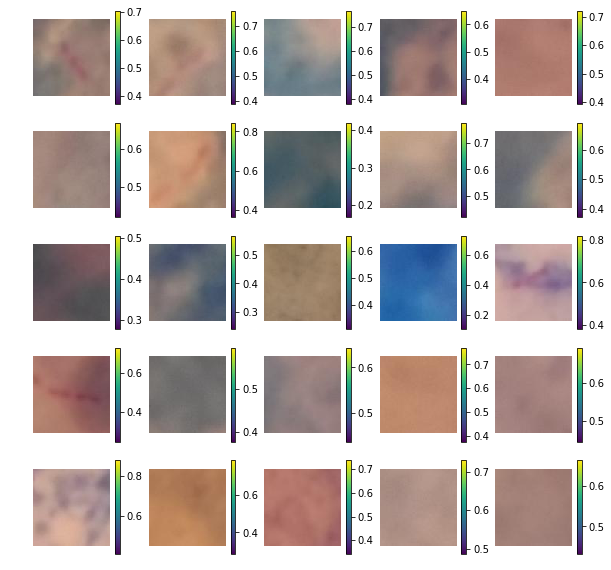

In [12]:
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i]/255)
        plt.colorbar()
        plt.axis('off')
    plt.show()

plot_examples(image.eval())

In [13]:
loss_list_train, sensitivity_train, specificity_train, acc_list_train = train_loop_train(10000)

loss is  5.6805735
loss is  0.26257095
loss is  0.1035595


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-cb4bc6a5ed4f>", line 1, in <module>
    loss_list_train, sensitivity_train, specificity_train, acc_list_train = train_loop_train(10000)
  File "<ipython-input-7-1aa027c2d0b9>", line 12, in train_loop_train
    _, loss_i, prediction, truth = sess.run([train_op, loss, logits, y_batch])
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\client\session.py", line 877, in run
    run_metadata_ptr)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\client\session.py", line 1100, in _run
    feed_dict_tensor, options, run_metadata)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\client\session.py", line 1272, in _do_run
    run_metadata)
  File "D:\Anaconda3\lib\site-packages\tensorflow\python\client\session.py", line 1278, in _do_call
    return fn(*args)
  File "

KeyboardInterrupt: 

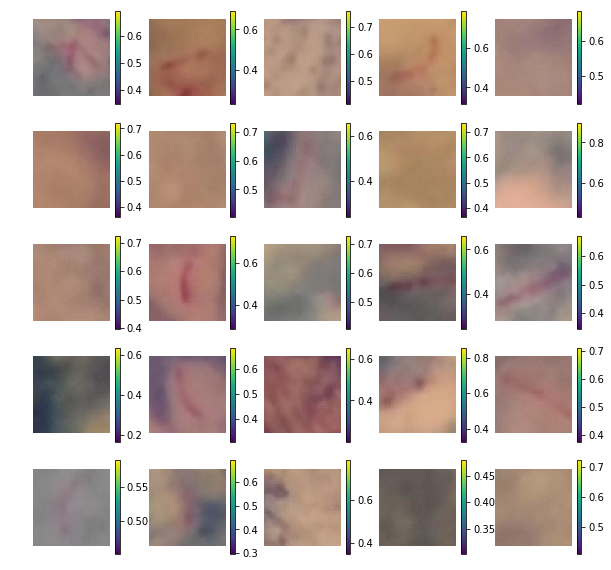

In [88]:
# plot examples 
plot_examples(image.eval())

In [89]:
# this code tells our batch_generator to generate test batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_val, y_train_or_test: y_val})

loss_list_test, sensitivity_test, specificity_test, acc_list_test = train_loop_val(100)

loss is  0.051669255
loss is  0.3944044
loss is  0.099699005
loss is  0.06787107
loss is  0.19908172
loss is  0.2039094
loss is  0.067880936
loss is  0.19200817
loss is  0.17827836
loss is  0.043946654
Accuracy is:
0.9421355498721228
Sensitivity is:
0.936485532815808
Specificity is:
0.9468147282291058


### function for plots

In [90]:
def plot_and_calculate(loss_train, acc_train, loss_test, acc_test):
    plt.plot(loss_train, 'r-o')
    plt.title("Training loss")
    plt.show()
    plt.plot(acc_train,'g-o')
    plt.title("Training accuracy")
    plt.show()
    plt.plot(loss_test, 'r-o')
    plt.title("Validation loss")
    plt.show()
    plt.plot(acc_test,'g-o')
    plt.title("Validation accuracy")
    plt.show()  

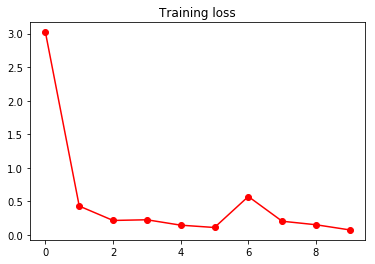

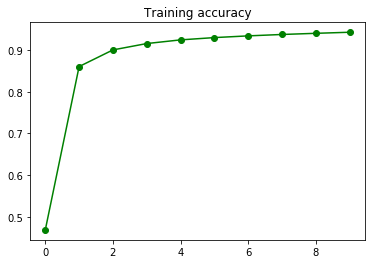

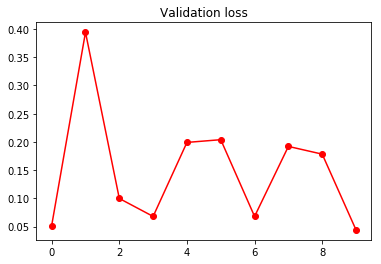

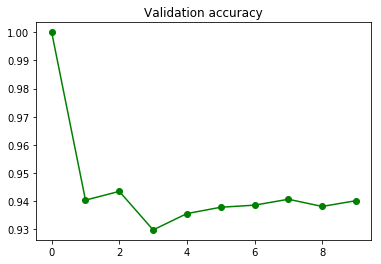

In [91]:
plot_and_calculate(loss_list_train, acc_list_train, loss_list_test, acc_list_test)

In [92]:
## Trainning result of the weights of each channel

In [93]:
sess.run(w_r)

0.99327266

In [94]:
sess.run(w_g)

1.0004733

In [95]:
sess.run(w_b)

1.0

## Classification without training of color channels

In [105]:
train_r = False
train_g = False
train_b = False
mask_r = w_r*np.ones([100,100,1])
mask_g = w_g*np.ones([100,100,1])
mask_b = w_g*np.ones([100,100,1])
mask = tf.concat((mask_r, mask_g, mask_b), 2)
image = mask * X_batch

In [106]:
net = image[...]  # add a channels dimension

# add some convolutional layers:
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# add some more if you want:
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# fully connected layers:
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=512, activation=tf.nn.relu)
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=2)

# define your CNN here
logits = net

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=2), logits=logits)

# boilerplate code:
train_op = tf.train.GradientDescentOptimizer(learning_rate=.0001).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})

In [107]:
loss_train, sensitivity, specificity, acc_train = train_loop_train(10000)

loss is  9.623901
loss is  0.2646302
loss is  0.09761156
loss is  0.33221912
loss is  0.33315334
loss is  0.14068626
loss is  0.11983209
loss is  0.12368828
loss is  0.08181269
loss is  0.07164177
Accuracy is:
0.9390487960953086
Sensitivity is:
0.9177653419330362
Specificity is:
0.9550999521286254


In [108]:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_val, y_train_or_test: y_val})
loss_test, sensitivity, specificity, acc_test = train_loop_val(100)

loss is  0.047712613
loss is  0.20166644
loss is  0.06522758
loss is  0.07511877
loss is  0.18961444
loss is  0.30734456
loss is  0.042386606
loss is  0.15787667
loss is  0.19745918
loss is  0.077124774
Accuracy is:
0.9478900255754475
Sensitivity is:
0.9407198306280875
Specificity is:
0.9538281706604325


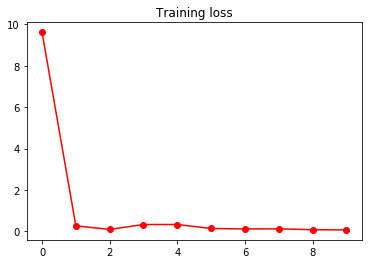

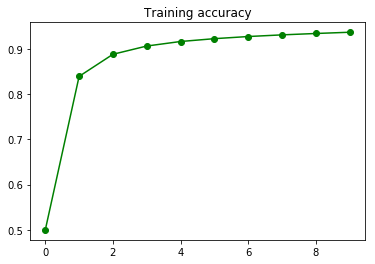

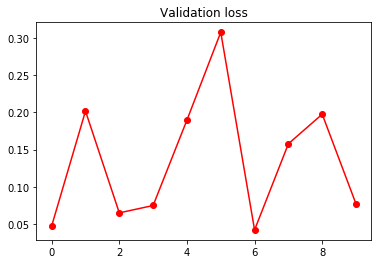

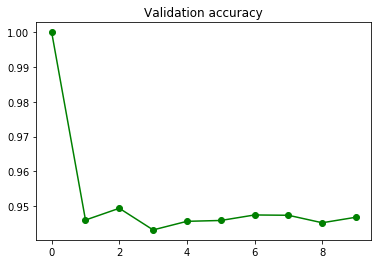

In [109]:
plot_and_calculate(loss_train, acc_train, loss_test, acc_test)

## learning rate = 0.001

(8076, 100, 100, 3)
(8076,)
Training data shape (7268, 100, 100, 3)


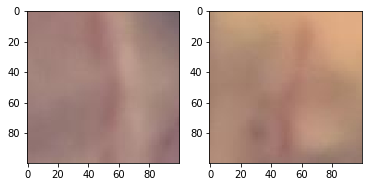

In [110]:
import os
import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def read_feature(folder, num):
    filename = glob.glob(os.path.join(folder, '*'))
    img_arr = np.zeros([len(filename), 100, 100, 3])
    label = num * np.ones(len(filename), dtype="float32")
    for i, name in enumerate(filename):
        img = Image.open(name)
        img_arr[i, :, :, :] = np.asarray(img, dtype="uint8")
    return img_arr, label

tb_img_arr, tb_label = read_feature('./TB_Image', 1)
non_tb_img_arr, non_tb_label = read_feature('./Non-TB_Image', 0)
images = np.concatenate((tb_img_arr, non_tb_img_arr))
labels = np.concatenate((tb_label, non_tb_label))

print(np.shape(images))
print(np.shape(labels))
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1)

X_train = X_train.astype(np.uint8)
X_val = X_val.astype(np.uint8)
y_train = y_train.astype(np.uint8)
y_val = y_val.astype(np.uint8)

# change into one-hot vector
#y_train = tf.keras.utils.to_categorical(y_train, 2) 
#y_val = tf.keras.utils.to_categorical(y_val, 2)

# reshape dataset
X_train = X_train.reshape(X_train.shape[0], 100, 100, 3)
X_val = X_val.reshape(X_val.shape[0], 100, 100, 3)

from matplotlib import pyplot as plt
%matplotlib inline

print('Training data shape', X_train.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(100, 100, 3), cmap=plt.cm.Greys);
ax2.imshow(X_train[1].reshape(100, 100, 3), cmap=plt.cm.Greys);

# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.float32, [None, 100, 100, 3], name='input_image')
y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
batch_size = 32
# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.batch(batch_size).repeat(None)
batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

In [111]:
train_r = True
w_r = tf.Variable(1,dtype=np.float32,trainable=train_r)
train_g = True
w_g = tf.Variable(1,dtype=np.float32,trainable=train_g)
train_b = True
w_b = tf.Variable(1,dtype=np.float32,trainable=train_b)

mask_r = w_r*np.ones([100,100,1])
mask_g = w_g*np.ones([100,100,1])
mask_b = w_g*np.ones([100,100,1])
mask = tf.concat((mask_r, mask_g, mask_b), 2)

print(np.shape(mask))

image = mask * X_batch

(100, 100, 3)


In [112]:
net = image[...]  # add a channels dimension

# add some convolutional layers:
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# add some more if you want:
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# fully connected layers:
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=512, activation=tf.nn.relu)
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=2)

# define your CNN here
logits = net

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=2), logits=logits)

# boilerplate code:
train_op = tf.train.GradientDescentOptimizer(learning_rate=.001).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# this code tells our batch_generator to generate training batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})

In [113]:
loss_train, sensitivity, specificity, acc_train = train_loop_train(10000)

loss is  3.5062757
loss is  0.68789405
loss is  0.6701597
loss is  0.6723013
loss is  0.68535024
loss is  0.67751014
loss is  0.6934379
loss is  0.67713356
loss is  0.68534744
loss is  0.69376075
Accuracy is:
0.5669550433506066
Sensitivity is:
0.0003042552266701439
Specificity is:
0.9997067838056143


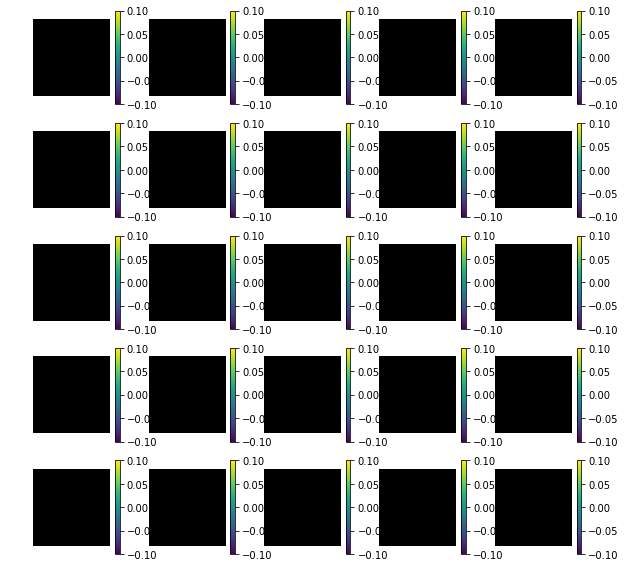

In [114]:
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i]/255)
        plt.colorbar()
        plt.axis('off')
    plt.show()

plot_examples(image.eval())

In [115]:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_val, y_train_or_test: y_val})
loss_test, sensitivity, specificity, acc_test = train_loop_val(100)

loss is  0.6769134
loss is  0.6769159
loss is  0.6600013
loss is  0.6769059
loss is  0.6938323
loss is  0.65997106
loss is  0.6853639
loss is  0.67687815
loss is  0.69385886
loss is  0.6768654
Accuracy is:
0.5728900255754475
Sensitivity is:
0.0
Specificity is:
1.0


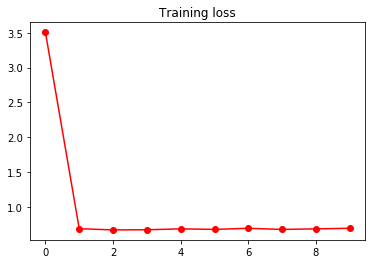

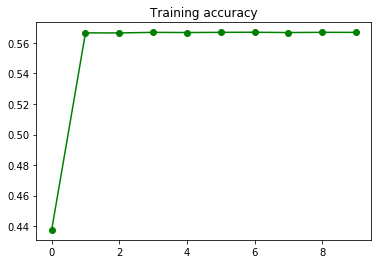

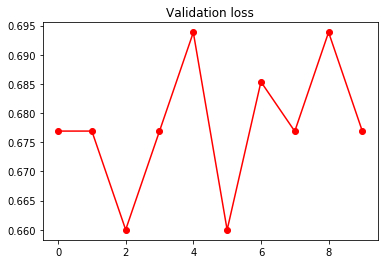

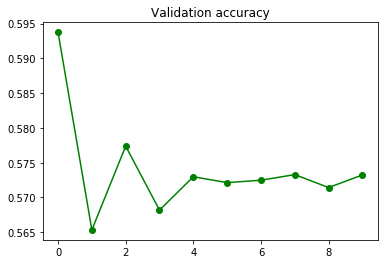

In [116]:
plot_and_calculate(loss_train, acc_train, loss_test, acc_test)

In [117]:
sess.run(w_r)

nan

In [118]:
sess.run(w_g)

nan

In [119]:
sess.run(w_b)

1.0

### learning rate = 0.00001

(8076, 100, 100, 3)
(8076,)
Training data shape (7268, 100, 100, 3)


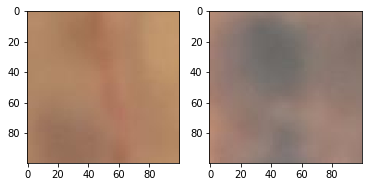

In [120]:
import os
import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def read_feature(folder, num):
    filename = glob.glob(os.path.join(folder, '*'))
    img_arr = np.zeros([len(filename), 100, 100, 3])
    label = num * np.ones(len(filename), dtype="float32")
    for i, name in enumerate(filename):
        img = Image.open(name)
        img_arr[i, :, :, :] = np.asarray(img, dtype="uint8")
    return img_arr, label

tb_img_arr, tb_label = read_feature('./TB_Image', 1)
non_tb_img_arr, non_tb_label = read_feature('./Non-TB_Image', 0)
images = np.concatenate((tb_img_arr, non_tb_img_arr))
labels = np.concatenate((tb_label, non_tb_label))

print(np.shape(images))
print(np.shape(labels))
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1)

X_train = X_train.astype(np.uint8)
X_val = X_val.astype(np.uint8)
y_train = y_train.astype(np.uint8)
y_val = y_val.astype(np.uint8)

# change into one-hot vector
#y_train = tf.keras.utils.to_categorical(y_train, 2) 
#y_val = tf.keras.utils.to_categorical(y_val, 2)

# reshape dataset
X_train = X_train.reshape(X_train.shape[0], 100, 100, 3)
X_val = X_val.reshape(X_val.shape[0], 100, 100, 3)

from matplotlib import pyplot as plt
%matplotlib inline

print('Training data shape', X_train.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(100, 100, 3), cmap=plt.cm.Greys);
ax2.imshow(X_train[1].reshape(100, 100, 3), cmap=plt.cm.Greys);

# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.float32, [None, 100, 100, 3], name='input_image')
y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
batch_size = 32
# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.batch(batch_size).repeat(None)
batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

In [121]:
train_r = True
w_r = tf.Variable(1,dtype=np.float32,trainable=train_r)
train_g = True
w_g = tf.Variable(1,dtype=np.float32,trainable=train_g)
train_b = True
w_b = tf.Variable(1,dtype=np.float32,trainable=train_b)
#w_colors = [w_r, w_g, w_b]

mask_r = w_r*np.ones([100,100,1])
mask_g = w_g*np.ones([100,100,1])
mask_b = w_g*np.ones([100,100,1])
mask = tf.concat((mask_r, mask_g, mask_b), 2)

image = mask * X_batch

In [122]:
net = image[...]  # add a channels dimension

# add some convolutional layers:
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# add some more if you want:
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# fully connected layers:
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=512, activation=tf.nn.relu)
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=2)

# define your CNN here
logits = net

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=2), logits=logits)

# boilerplate code:
train_op = tf.train.GradientDescentOptimizer(learning_rate=.00001).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# this code tells our batch_generator to generate training batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})

In [123]:
loss_train, sensitivity, specificity, acc_train = train_loop_train(10000)

loss is  4.135911
loss is  0.53483856
loss is  0.2776823
loss is  0.22008185
loss is  0.19301975
loss is  0.16962098
loss is  0.27980953
loss is  0.20337239
loss is  0.076367185
loss is  0.08176283
Accuracy is:
0.9021254971831516
Sensitivity is:
0.8693951161336301
Specificity is:
0.9269535861254841


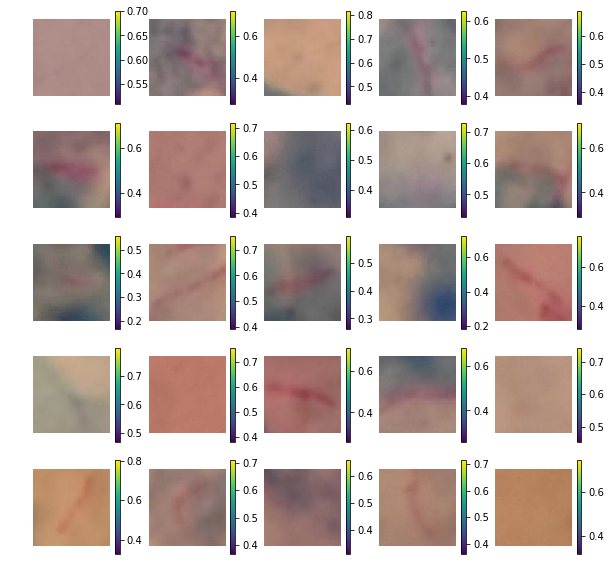

In [124]:
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i]/255)
        plt.colorbar()
        plt.axis('off')
    plt.show()

plot_examples(image.eval())

In [125]:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_val, y_train_or_test: y_val})
loss_test, sensitivity, specificity, acc_test = train_loop_val(100)

loss is  0.19898635
loss is  0.5052868
loss is  0.30421215
loss is  0.13698354
loss is  0.12067567
loss is  0.20584765
loss is  0.22343606
loss is  0.08635003
loss is  0.07590924
loss is  0.11887148
Accuracy is:
0.9424552429667519
Sensitivity is:
0.9190751445086706
Specificity is:
0.9610091743119266


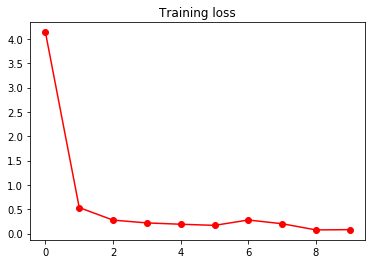

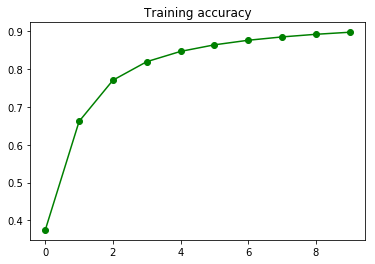

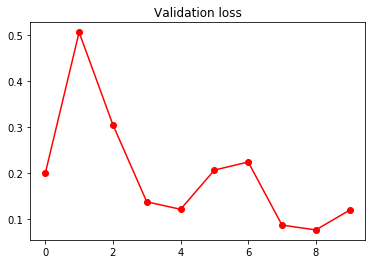

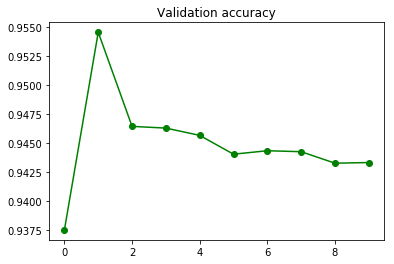

In [126]:
plot_and_calculate(loss_train, acc_train, loss_test, acc_test)

In [127]:
sess.run(w_r)

0.9934838

In [128]:
sess.run(w_g)

1.004147

In [129]:
sess.run(w_b)

1.0

### learning rate = 0.01

(8076, 100, 100, 3)
(8076,)
Training data shape (7268, 100, 100, 3)


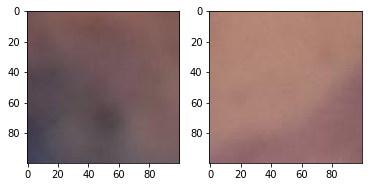

In [130]:
import os
import glob
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def read_feature(folder, num):
    filename = glob.glob(os.path.join(folder, '*'))
    img_arr = np.zeros([len(filename), 100, 100, 3])
    label = num * np.ones(len(filename), dtype="float32")
    for i, name in enumerate(filename):
        img = Image.open(name)
        img_arr[i, :, :, :] = np.asarray(img, dtype="uint8")
    return img_arr, label

tb_img_arr, tb_label = read_feature('./TB_Image', 1)
non_tb_img_arr, non_tb_label = read_feature('./Non-TB_Image', 0)
images = np.concatenate((tb_img_arr, non_tb_img_arr))
labels = np.concatenate((tb_label, non_tb_label))

print(np.shape(images))
print(np.shape(labels))
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1)

X_train = X_train.astype(np.uint8)
X_val = X_val.astype(np.uint8)
y_train = y_train.astype(np.uint8)
y_val = y_val.astype(np.uint8)

# change into one-hot vector
#y_train = tf.keras.utils.to_categorical(y_train, 2) 
#y_val = tf.keras.utils.to_categorical(y_val, 2)

# reshape dataset
X_train = X_train.reshape(X_train.shape[0], 100, 100, 3)
X_val = X_val.reshape(X_val.shape[0], 100, 100, 3)

from matplotlib import pyplot as plt
%matplotlib inline

print('Training data shape', X_train.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(100, 100, 3), cmap=plt.cm.Greys);
ax2.imshow(X_train[1].reshape(100, 100, 3), cmap=plt.cm.Greys);

# this can be either X_train/y_train or X_test/y_test, so we make a placeholder that we can feed into:
X_train_or_test = tf.placeholder(tf.float32, [None, 100, 100, 3], name='input_image')
y_train_or_test = tf.placeholder(tf.int32, [None], name='image_label')
batch_size = 32
# create a tf dataset, from which we can generate batches
dataset = tf.data.Dataset.from_tensor_slices((X_train_or_test, y_train_or_test))
dataset = dataset.batch(batch_size).repeat(None)
batch_generator = dataset.make_initializable_iterator()
X_batch, y_batch = batch_generator.get_next()  # batches symbolically generated

In [131]:
train_r = True
w_r = tf.Variable(1,dtype=np.float32,trainable=train_r)
train_g = True
w_g = tf.Variable(1,dtype=np.float32,trainable=train_g)
train_b = True
w_b = tf.Variable(1,dtype=np.float32,trainable=train_b)
#w_colors = [w_r, w_g, w_b]

mask_r = w_r*np.ones([100,100,1])
mask_g = w_g*np.ones([100,100,1])
mask_b = w_g*np.ones([100,100,1])
mask = tf.concat((mask_r, mask_g, mask_b), 2)

image = mask * X_batch

In [132]:
net = image[...]  # add a channels dimension

# add some convolutional layers:
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# add some more if you want:
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.conv2d(net, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
net = tf.layers.max_pooling2d(net, pool_size=2, strides=2)

# fully connected layers:
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=512, activation=tf.nn.relu)
net = tf.layers.flatten(net)
net = tf.layers.dense(net, units=2)

# define your CNN here
logits = net

loss = tf.losses.softmax_cross_entropy(onehot_labels=tf.one_hot(y_batch, depth=2), logits=logits)

# boilerplate code:
train_op = tf.train.GradientDescentOptimizer(learning_rate=.01).minimize(loss)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# this code tells our batch_generator to generate training batches:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_train, y_train_or_test: y_train})

In [133]:
loss_train, sensitivity, specificity, acc_train = train_loop_train(10000)

loss is  5.6241546
loss is  0.66102344
loss is  0.6697043
loss is  0.6598862
loss is  0.70102125
loss is  0.669492
loss is  0.7182753
loss is  0.6693684
loss is  0.7099199
loss is  0.6771879
Accuracy is:
0.5636457170102511
Sensitivity is:
0.0002947646915035875
Specificity is:
0.9996939377413718


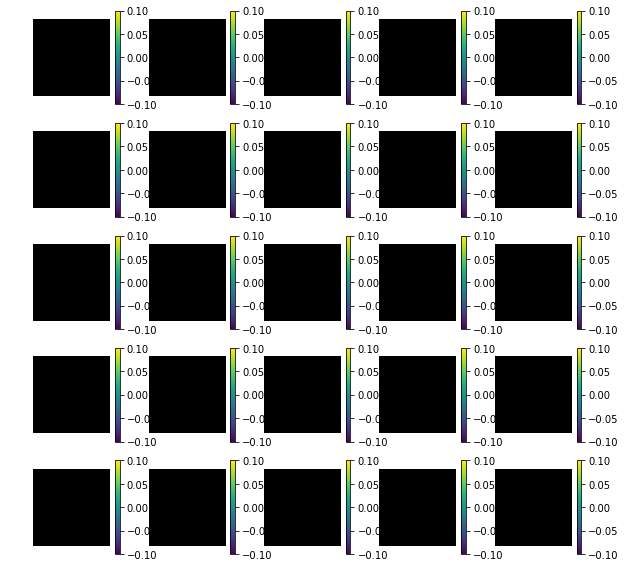

In [134]:
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(batch[i]/255)
        plt.colorbar()
        plt.axis('off')
    plt.show()

plot_examples(image.eval())

In [135]:
sess.run(batch_generator.initializer, feed_dict={X_train_or_test: X_val, y_train_or_test: y_val})
loss_test, sensitivity, specificity, acc_test = train_loop_val(100)

loss is  0.6693177
loss is  0.66899663
loss is  0.6684866
loss is  0.67683387
loss is  0.68541205
loss is  0.67645264
loss is  0.67645
loss is  0.66699123
loss is  0.6855833
loss is  0.68566966
Accuracy is:
0.6016624040920716
Sensitivity is:
0.0
Specificity is:
1.0


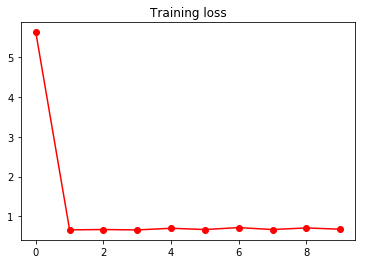

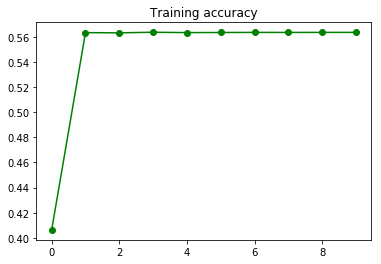

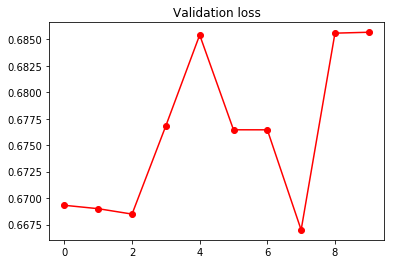

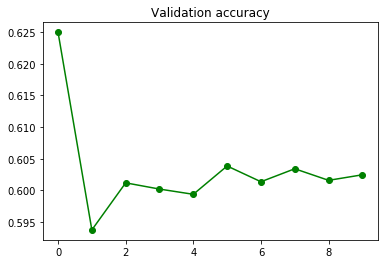

In [136]:
plot_and_calculate(loss_train, acc_train, loss_test, acc_test)

In [137]:
sess.run(w_r)

nan

In [138]:
sess.run(w_g)

nan

In [139]:
sess.run(w_b)

1.0